In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Đọc dữ liệu từ file CSV
matches_df = pd.read_csv("../../../data_for_training/MU.csv")

In [3]:
# Chọn các tính năng và loại bỏ biến mục tiêu nếu nó đã được bao gồm trong dữ liệu
X = matches_df.drop(['result'], axis=1)

## Chuẩn Hóa Dữ Liệu

In [4]:
# Xác định các cột phân loại và cột số
categorical_cols = ['venue', 'season']
numerical_cols = [col for col in X if col not in categorical_cols]

In [5]:
# Tiền xử lý các cột phân loại
preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

In [6]:
X_transformed = preprocessor.fit_transform(X)

### Áp dụng kmeans

#### Trực quan hóa

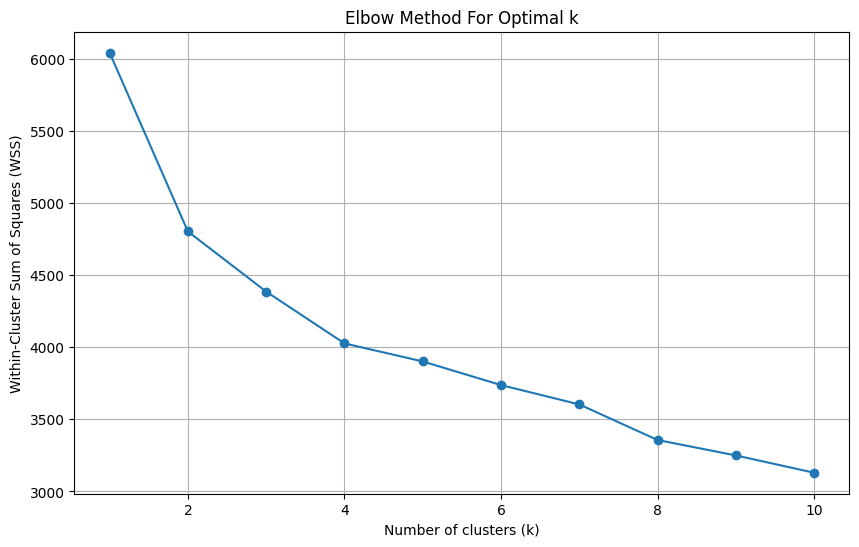

In [7]:
# Tính WSS cho một phạm vi số cụm từ 1 đến 10
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_transformed)
    wss.append(kmeans.inertia_)  # inertia_ là thuộc tính chứa tổng bình phương khoảng cách

# Vẽ đồ thị Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.grid(True)
plt.show()

In [8]:
# Chọn số lượng cụm
k = 3  # Có thể thay đổi số này sau khi phân tích (ví dụ: sử dụng phương pháp Elbow)

# Phân cụm
kmeans = KMeans(n_clusters=k, random_state=42)
matches_df['Cluster'] = kmeans.fit_predict(X_transformed)


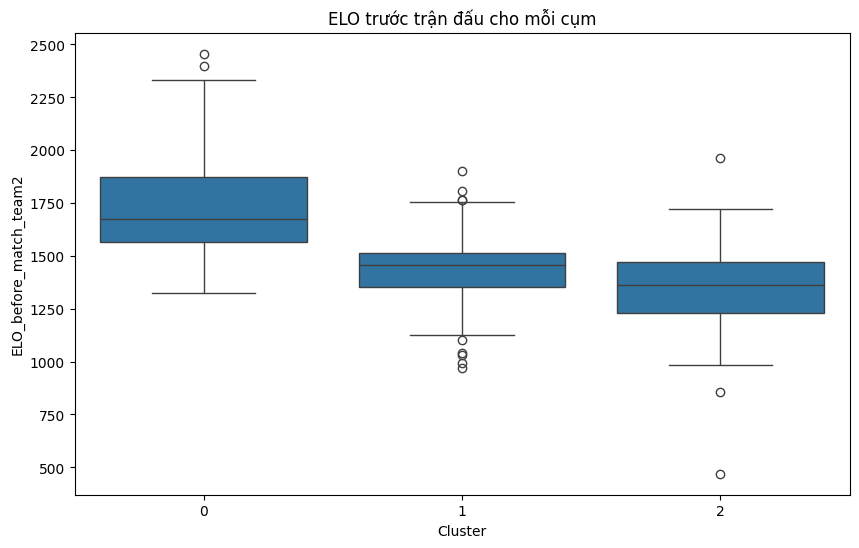

F-value: 161.3974438252272 P-value: 1.4071307081784532e-52


In [9]:
# Biểu đồ hộp cho biến 'ELO_before_match_team2'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='ELO_before_match_team2', data=matches_df)
plt.title('ELO trước trận đấu cho mỗi cụm')
plt.show()

# Kiểm định ANOVA cho biến 'ELO_before_match_team2' để xem sự khác biệt giữa các cụm
import scipy.stats as stats

f_value, p_value = stats.f_oneway(matches_df[matches_df['Cluster'] == 0]['ELO_before_match_team2'],
                                  matches_df[matches_df['Cluster'] == 1]['ELO_before_match_team2'],
                                  matches_df[matches_df['Cluster'] == 2]['ELO_before_match_team2'])
print('F-value:', f_value, 'P-value:', p_value)


- Cụm 0: Đối Thủ Yếu
- Cụm 1: Đối Thủ Trung Bình
- Cụm 2: Đối Thủ Mạnh

#### Vẽ cụm theo không gian 2 chiều

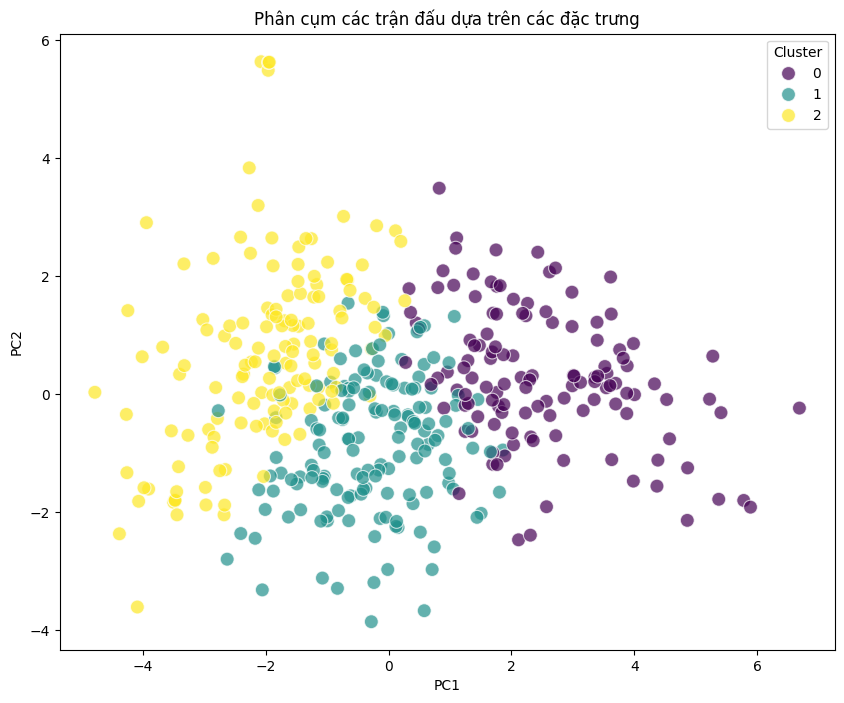

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Giảm chiều dữ liệu xuống 2D để trực quan hóa
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_transformed)

# Tạo DataFrame cho việc trực quan hóa
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = matches_df['Cluster']

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7, s=100)
plt.title('Phân cụm các trận đấu dựa trên các đặc trưng')
plt.show()


#### Gán nhãn cho từng cụm

In [11]:
# Gán nhãn cho từng cụm
def assign_cluster_label(cluster):
    if cluster == 0:
        return 'Average Opponent'
    elif cluster == 1:
        return 'Weak Opponent'
    elif cluster == 2:
        return 'Strong Opponent'
    else:
        return 'Unknown'

# Thêm cột match_type vào DataFrame
matches_df['match_type'] = matches_df['Cluster'].apply(assign_cluster_label)

# Kiểm tra kết quả
print(matches_df[['Cluster', 'match_type']].head())


   Cluster        match_type
0        1     Weak Opponent
1        2   Strong Opponent
2        1     Weak Opponent
3        2   Strong Opponent
4        0  Average Opponent


In [12]:
# Lưu DataFrame vào một tệp CSV
matches_df.to_csv('MU_clustered.csv', index=False)